In [58]:

"""NEXT STEPS:

DATA:
1. STORE HISTORICAL DATA
    a. Get recession dates loaded
    b. Convert all series to daily (generic function)
    https://stackoverflow.com/questions/19324453/add-missing-dates-to-pandas-dataframe
    c. Adjust for inflation where necessary (generic function)
    d. Feature Engineering (trended attributes, etc..)
    e. Load to db

MODEL:
2. Employ Prophet for TimeSeries modelling
    a. 1 Model with wide prediction range (3mo)
    b. 1 Model with short perdiction range (1mo)
3. Re-run 'best' models every day and check against prior scores

DATA Part2:
4. DATA UPDATE PROCESS
    a. daily check for each dataset
    b. repeat steps 1b/1c
    c. email alerts if data update fails

ALERTS:
5. Email Alerts if model scores change within a tolerance

"""

"""
Goal: To build a basic economic model for the US Economy in order to roughly predict 
a downturn. Prob(downturn in 3 months). 

Steps: 
Gather quality data in time-series
Train/Test model
Automate from the outset so model can ingest new data and re-run daily
Alert if target probability exceeds alert threshold

Data sources:
FRED Data (st louis federal reserve) - https://fred.stlouisfed.org/
FRED API - https://github.com/mortada/fredapi
List of other datasets: https://www.aeaweb.org/rfe/showCat.php?cat_id=3

Indicators we care about:
Private Debt, Household Debt vs. GDP
Personal Income
Unemployment Rate
Interest rates
Monetary Supply
CPI
GDP
Public Debt
Credit in the economy
VIX index
Total US Population
YieldCurve/Treasury spreads (2-10yr bonds)
S&P500 - Measure of total us stock market prices(target)
Charge Off Rates - FED published for top banks, other source as well
"""

import json, sqlite3, os, sys, datetime, urllib
import pandas as pd
import numpy as np
from fredapikey import apikey
from fredapi import Fred
from functools import reduce
from zipfile import ZipFile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

verbose = 1
dir_path = '.'
dbpathname = '/stego.db'
fred = Fred(api_key=apikey)

#Create or Connect to existing Sqlite DB
if not os.path.isfile(str(dir_path)+dbpathname):
    con=dbprocess(path=dir_path)

con = sqlite3.connect(str(dir_path)+dbpathname) #connect to existing sqlite db
cur = con.cursor()

In [3]:
def echo(msg, verbosity=verbose):
    if verbosity == 1:
        print(msg) 
    else:
        return None

def dbprocess(path):
    try:
        echo(msg='Loading DB...',verbosity=1)
        con = sqlite3.connect(str(path)+dbpathname) #connect to existing or create new if does not exist
        cur = con.cursor()
        cur.execute('CREATE TABLE daily_trades([index] bigint, asset varchar(5), exchange varchar(100), time_start datetime, time_end datetime, trades_count bigint, volume_traded decimal(20,10), price_open decimal(20,10), price_high decimal(20,10), price_low decimal(20,10), price_close decimal(20,10))')
        #cur.execute('CREATE INDEX IDX_time ON daily_trades (time_start, time_end)')
        con.commit()
    except sqlite3.Error as e:
        echo(msg="Error {}:".format(e.args[0]),verbosity=1)
        os._exit(1)
    finally:
        if con:
            con.close()

def dailyresample(data, seriesname):
    #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
    #https://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    if isinstance(data, pd.Series):
        s = data.resample('D').pad()
        df = s.to_frame(name=seriesname)
        df.index.name='date'
        return df
    else:
        print('not a pandas series - need code')
        raise

In [139]:
#Historical Data Load
#   Recession Dates
dtype = {'c':str,'d':str,'e':int,'f':int,'g':int,'h':int,'i':int,'j':int}
rcs_df = pd.read_excel(io=dir_path+"/required/NBER chronology.xlsx",
                    sheet_name=0,
                    header=2,
                    usecols="C:J",
                    dtype=dtype,
                    nrows=34)
rcs_df['Peak month'] = rcs_df['Peak month'].apply(lambda x: '01 {}'.format(x))
rcs_df['Trough month'] = rcs_df['Trough month'].apply(lambda x: '01 {}'.format(x))
df_dates = pd.to_datetime(rcs_df[['Peak month','Trough month']].stack(),errors='coerce',format='%d %B %Y').unstack()
rcs_df = pd.merge(rcs_df, df_dates, left_index=True, right_index=True)[['Peak month_y','Trough month_y','Peak month number','Trough month number','Duration, peak to trough','Duration, trough to peak','Duration, trough to trough','Duration, peak to peak']]
rcs_df.rename(index=str, columns={'Peak month_y': 'Peak month','Trough month_y': 'Trough month'}, inplace=True)

#   S&P500 History (Macrotrends data from Dec-1927)
#   https://macrotrends.dpdcart.com/product/126227
sp_df = pd.read_csv(filepath_or_buffer=dir_path+"/required/Macrotrends-s-p-500-index-daily.csv",
                    delimiter=',',
                    skiprows=8,
                    header=0,
                    usecols=[0,1],
                    dtype=dtype)
sp_df.set_index(pd.DatetimeIndex(sp_df['Date']),inplace=True)
sp_df.drop(columns=['Date'],inplace=True)
sp_df.rename(columns={'Closing Value': 'SP500'},inplace=True)
sp_df = dailyresample(data=sp_df['SP500'],seriesname='SP500')

#   S&P500 History (Shiller simulated monthly data from Jan-1871)
try:
    shiller_df = pd.read_excel(io=dir_path+"/required/ie_data.xls",
                            sheet_name="Data",
                            header=7,
                            usecols="A:B,K",
                            nrows=1773)
except:
    #   http://www.econ.yale.edu/~shiller/data/ie_data.xls
    urllib.request.urlretrieve('http://www.econ.yale.edu/~shiller/data/ie_data.xls','./required/ie_data.xls')
    shiller_df = pd.read_excel(io=dir_path+"/required/ie_data.xls",
                                sheet_name="Data",
                                header=7,
                                usecols="A:B,K",
                                nrows=1773)

shiller_df['Date'] = shiller_df['Date'].apply(lambda x: '{}0'.format(x)[:7]+'.01')
shiller_df.set_index(pd.DatetimeIndex(shiller_df['Date']),inplace=True)
shiller_df.drop(columns=['Date'],inplace=True)
shiller_df.rename(columns={'Closing Value': 'SP500'},inplace=True)
shiller_sp500 = dailyresample(data=shiller_df['P'],seriesname='SP500')
shiller_sp500 = shiller_sp500.loc[:'1927-12-29'] #remove dates that overlap with our other datasets

#   S&P500 History from FRED goes back to 2008
SP500 = fred.get_series('SP500')
SP500 = dailyresample(data=SP500,seriesname='SP500')
SP500 = SP500.loc['2018-10-12':]

SP500=pd.concat([shiller_sp500,sp_df,SP500]) #union all our normalized SP500 data. 


#Trend the S&P by 6mo, 12mo, 24mo. Compare current to prior highs from these periods. 
#Calc 'months before recession' feature (could be our target)



#CAPE index by Shiller
shiller_cape = dailyresample(data=shiller_df['CAPE'],seriesname='CAPE')
shiller_cape = shiller_cape.loc['1881-01-01':] #remove NaN dates

VIXCLS = fred.get_series('VIXCLS') #CBOE Volatility Index (VIX), Daily
VIXCLS = dailyresample(data=VIXCLS,seriesname='VIXCLS')

UMCSENT = fred.get_series('UMCSENT') # University of Michigan: Consumer Sentiment, Monthly
UMCSENT = dailyresample(data=UMCSENT,seriesname='UMCSENT')

STLFSI = fred.get_series('STLFSI') # St. Louis Fed Financial Stress Index, Weekly
STLFSI = dailyresample(data=STLFSI,seriesname='STLFSI')

#Need to adjust for inflation to get Real
NPPTTL = fred.get_series('NPPTTL') # Total Nonfarm Private Payroll Employment, Monthly
NPPTTL = dailyresample(data=NPPTTL,seriesname='NPPTTL')

PERMIT = fred.get_series('PERMIT') # New Private Housing Units Authorized by Building Permits, Monthly
PERMIT = dailyresample(data=PERMIT,seriesname='PERMIT')

DGORDER = fred.get_series('DGORDER') # Manufacturers' New Orders: Durable Goods, Seasonally Adjusted, Monthly
DGORDER = dailyresample(data=DGORDER,seriesname='DGORDER')


"""
The first indicator is the unemployment gap, which is the difference between the unemployment rate and the natural rate of unemployment (formerly called NAIRU, for the non-accelerating inflation rate of unemployment). 
A strong labor market prompts the Fed to tighten because an unemployment rate well below the natural rate is unsustainable by definition, and can lead to a spike in wage and price inflation. 
Looking at the current cycle, the labor market is in the early stages of overheating. We see unemployment heading to 3.5 percent, which would be consistent with the pre-recession behavior of the unemployment gap in past cycles.
"""
#Unemployment Gap  = Unemployment Rate – Natural Rate of Unemployment
NROU = fred.get_series('NROU') # Natural Rate of Unemployment (Long-Term), Quarterly
NROU = dailyresample(data=NROU,seriesname='NROU')

NROUST = fred.get_series('NROUST') # Natural Rate of Unemployment (Short-Term), Quarterly
NROUST = dailyresample(data=NROUST,seriesname='NROUST')

UNRATE = fred.get_series('UNRATE') # Civilian Unemployment Rate
UNRATE = dailyresample(data=UNRATE,seriesname='UNRATE')

UNRATE=pd.merge(UNRATE,NROU,how='left',on='date')
UNRATE=pd.merge(UNRATE,NROUST,how='left',on='date')
UNRATE['UNGAP']=UNRATE['UNRATE']-UNRATE['NROU']
UNRATE['UNGAPST']=UNRATE['UNRATE']-UNRATE['NROUST']
UNRATE[['UNGAP','UNGAPST']]=UNRATE[['UNGAP','UNGAPST']].fillna(0)

"""
One of the most reliable and consistent predictors of recession has been the Treasury yield curve. Recessions are always preceded by a flat or inverted yield curve, usually occurring about 12 months before the downturn begins. 
This occurs with T-bill yields rising as Fed policy becomes restrictive while 10-year yields rise at a slower pace. Looking at the current cycle, we expect that steady increases in the fed funds rate will continue to flatten the yield curve over the next 12–18 months.
Three Month–10 Year Treasury Yield Curve (bps)
"""
T10Y2Y = fred.get_series('T10Y2Y') # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity, Daily
T10Y2Y = dailyresample(data=T10Y2Y,seriesname='T10Y2Y')


"""
Other indicators of the real economy, including aggregate weekly hours, decline in the months preceding a recession as employers begin to reduce headcount and cut the length of the workweek. 
Looking at the current cycle, aggregate weekly hours growth has been steady, albeit at weaker than average levels, reflecting slower labor force growth as baby boomers retire. 
We expect growth in hours worked to hold up over the coming year before slowing more markedly in 2019.
Aggregate Weekly Hours Worked, Year-over-Year % Change
"""
HOHWMN02USM065S = fred.get_series('HOHWMN02USM065S') # Weekly Hours Worked: Manufacturing for the United States, Monthly
HOHWMN02USM065S = dailyresample(data=HOHWMN02USM065S,seriesname='HOHWMN02USM065S')


"""
Real retail sales growth weakens significantly before a recession begins, with the inflection point typically occurring about 12 months before the start of the recession. 
Consumers cut back on spending as they start to feel the impact of slowing real income growth. This shows up most noticeably in retail sales, which are made up of a higher share of discretionary purchases than other measures of consumption. 
Looking at the current cycle, real retail sales growth has been steady at around 2 percent. This is weaker than the historical average, but is consistent with slower-trend gross domestic product (GDP) growth in this cycle.
"""
#Need to adjust for inflation to get Real
RETAILSMSA = fred.get_series('RETAILSMSA') # Retailers Sales, Seasonally Adjusted, Monthly
RETAILSMSA = dailyresample(data=RETAILSMSA,seriesname='RETAILSMSA')

#CPI Index for INFLATION ADJUSTMENT (goes back to 1913)
CPIAUCNS = fred.get_series('CPIAUCNS') # Consumer Price Index for All Urban Consumers: All Items
CPIAUCNS = dailyresample(data=CPIAUCNS,seriesname='CPIAUCNS')
CPIAUCNS['CPIMultiplier'] = CPIAUCNS['CPIAUCNS'].iloc[-1] / CPIAUCNS['CPIAUCNS'] #index to today's prices


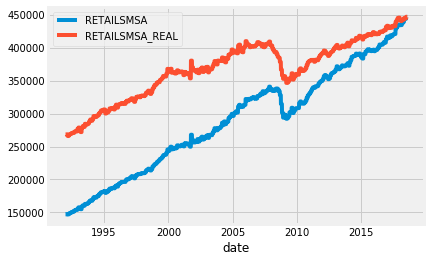

In [141]:
#Inflation Adjustments
RETAILSMSA=pd.merge(RETAILSMSA,CPIAUCNS,how='left',on='date')
RETAILSMSA['RETAILSMSA_REAL']=RETAILSMSA['RETAILSMSA']*RETAILSMSA['CPIMultiplier']
RETAILSMSA[['RETAILSMSA','RETAILSMSA_REAL']].plot()

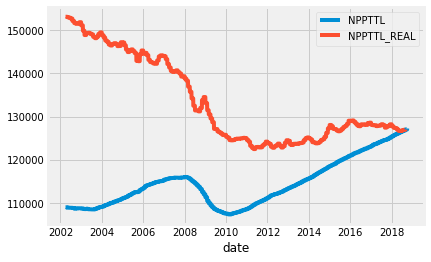

In [142]:
NPPTTL=pd.merge(NPPTTL,CPIAUCNS,how='left',on='date')
NPPTTL['NPPTTL_REAL']=NPPTTL['NPPTTL']*NPPTTL['CPIMultiplier']
NPPTTL[['NPPTTL','NPPTTL_REAL']].plot()

In [97]:
#Pull Economic Uncertainty Index
#https://www.sydneyludvigson.com/data-and-appendixes/
#https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip
try:
    zip_file = ZipFile('./required/MacroFinanceUncertainty_2018AUG_update.zip')
except:
    urllib.request.urlretrieve('https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip','./required/MacroFinanceUncertainty_2018AUG_update.zip')

econuncert_df = pd.read_csv(filepath_or_buffer=zip_file.open('MacroUncertaintyToCirculate.csv'),header=0)
econuncert_df.set_index(pd.DatetimeIndex(econuncert_df['Date']),inplace=True)
econuncert_df.drop(columns=['Date'],inplace=True)
econuncert_1_df = dailyresample(data=econuncert_df['h=1'],seriesname='econuncert_h1')
econuncert_3_df = dailyresample(data=econuncert_df['h=3'],seriesname='econuncert_h3')
econuncert_12_df = dailyresample(data=econuncert_df['h=12'],seriesname='econuncert_h12')

finuncert_df = pd.read_csv(filepath_or_buffer=zip_file.open('FinancialUncertaintyToCirculate.csv'),header=0)
finuncert_df.set_index(pd.DatetimeIndex(finuncert_df['Date']),inplace=True)
finuncert_df.drop(columns=['Date'],inplace=True)
finuncert_1_df = dailyresample(data=finuncert_df['h=1'],seriesname='finuncert_h1')
finuncert_3_df = dailyresample(data=finuncert_df['h=3'],seriesname='finuncert_h3')
finuncert_12_df = dailyresample(data=finuncert_df['h=12'],seriesname='finuncert_h12')

#finuncert_1_df.head()

In [51]:
#Scrape LEI data from web (auto or manual)
#https://www.conference-board.org/data/bciarchive.cfm?cid=1

In [98]:
#Construct main dataframe indexed on our dates
start_date=datetime.date(1854,12,1)
end_date=datetime.datetime.today().date()
days=(end_date-start_date).days
index = pd.date_range(start=start_date, end=end_date)
s = pd.Series(range(days+1), index=index)
main_df = s.to_frame(name='daynum')

#Merge all dataframes into 1 dataset
#https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns
dfs = [main_df,SP500,VIXCLS,UMCSENT,STLFSI,NPPTTL['NPPTTL_REAL'],PERMIT,DGORDER,NROU,NROUST,T10Y2Y,HOHWMN02USM065S,RETAILSMSA['RETAILSMSA_REAL'],econuncert_1_df,econuncert_3_df,econuncert_12_df,finuncert_1_df,finuncert_3_df,finuncert_12_df]
main_df = reduce(lambda left,right: pd.merge(left,right,how='outer',left_index=True,right_index=True), dfs)

In [99]:
main_df[51000:].head()

,daynum,SP500,VIXCLS,UMCSENT,STLFSI,...,econuncert_h3,econuncert_h12,finuncert_h1,finuncert_h3,finuncert_h12
1994-07-20,51000.0,451.60,11.70,89.0,0.823,...,0.690776,0.859762,0.688454,0.767483,0.914404
1994-07-21,51001.0,452.61,11.65,89.0,0.823,...,0.690776,0.859762,0.688454,0.767483,0.914404
1994-07-22,51002.0,453.11,11.22,89.0,0.726,...,0.690776,0.859762,0.688454,0.767483,0.914404
1994-07-23,51003.0,453.11,11.22,89.0,0.726,...,0.690776,0.859762,0.688454,0.767483,0.914404
1994-07-24,51004.0,453.11,11.22,89.0,0.726,...,0.690776,0.859762,0.688454,0.767483,0.914404


/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


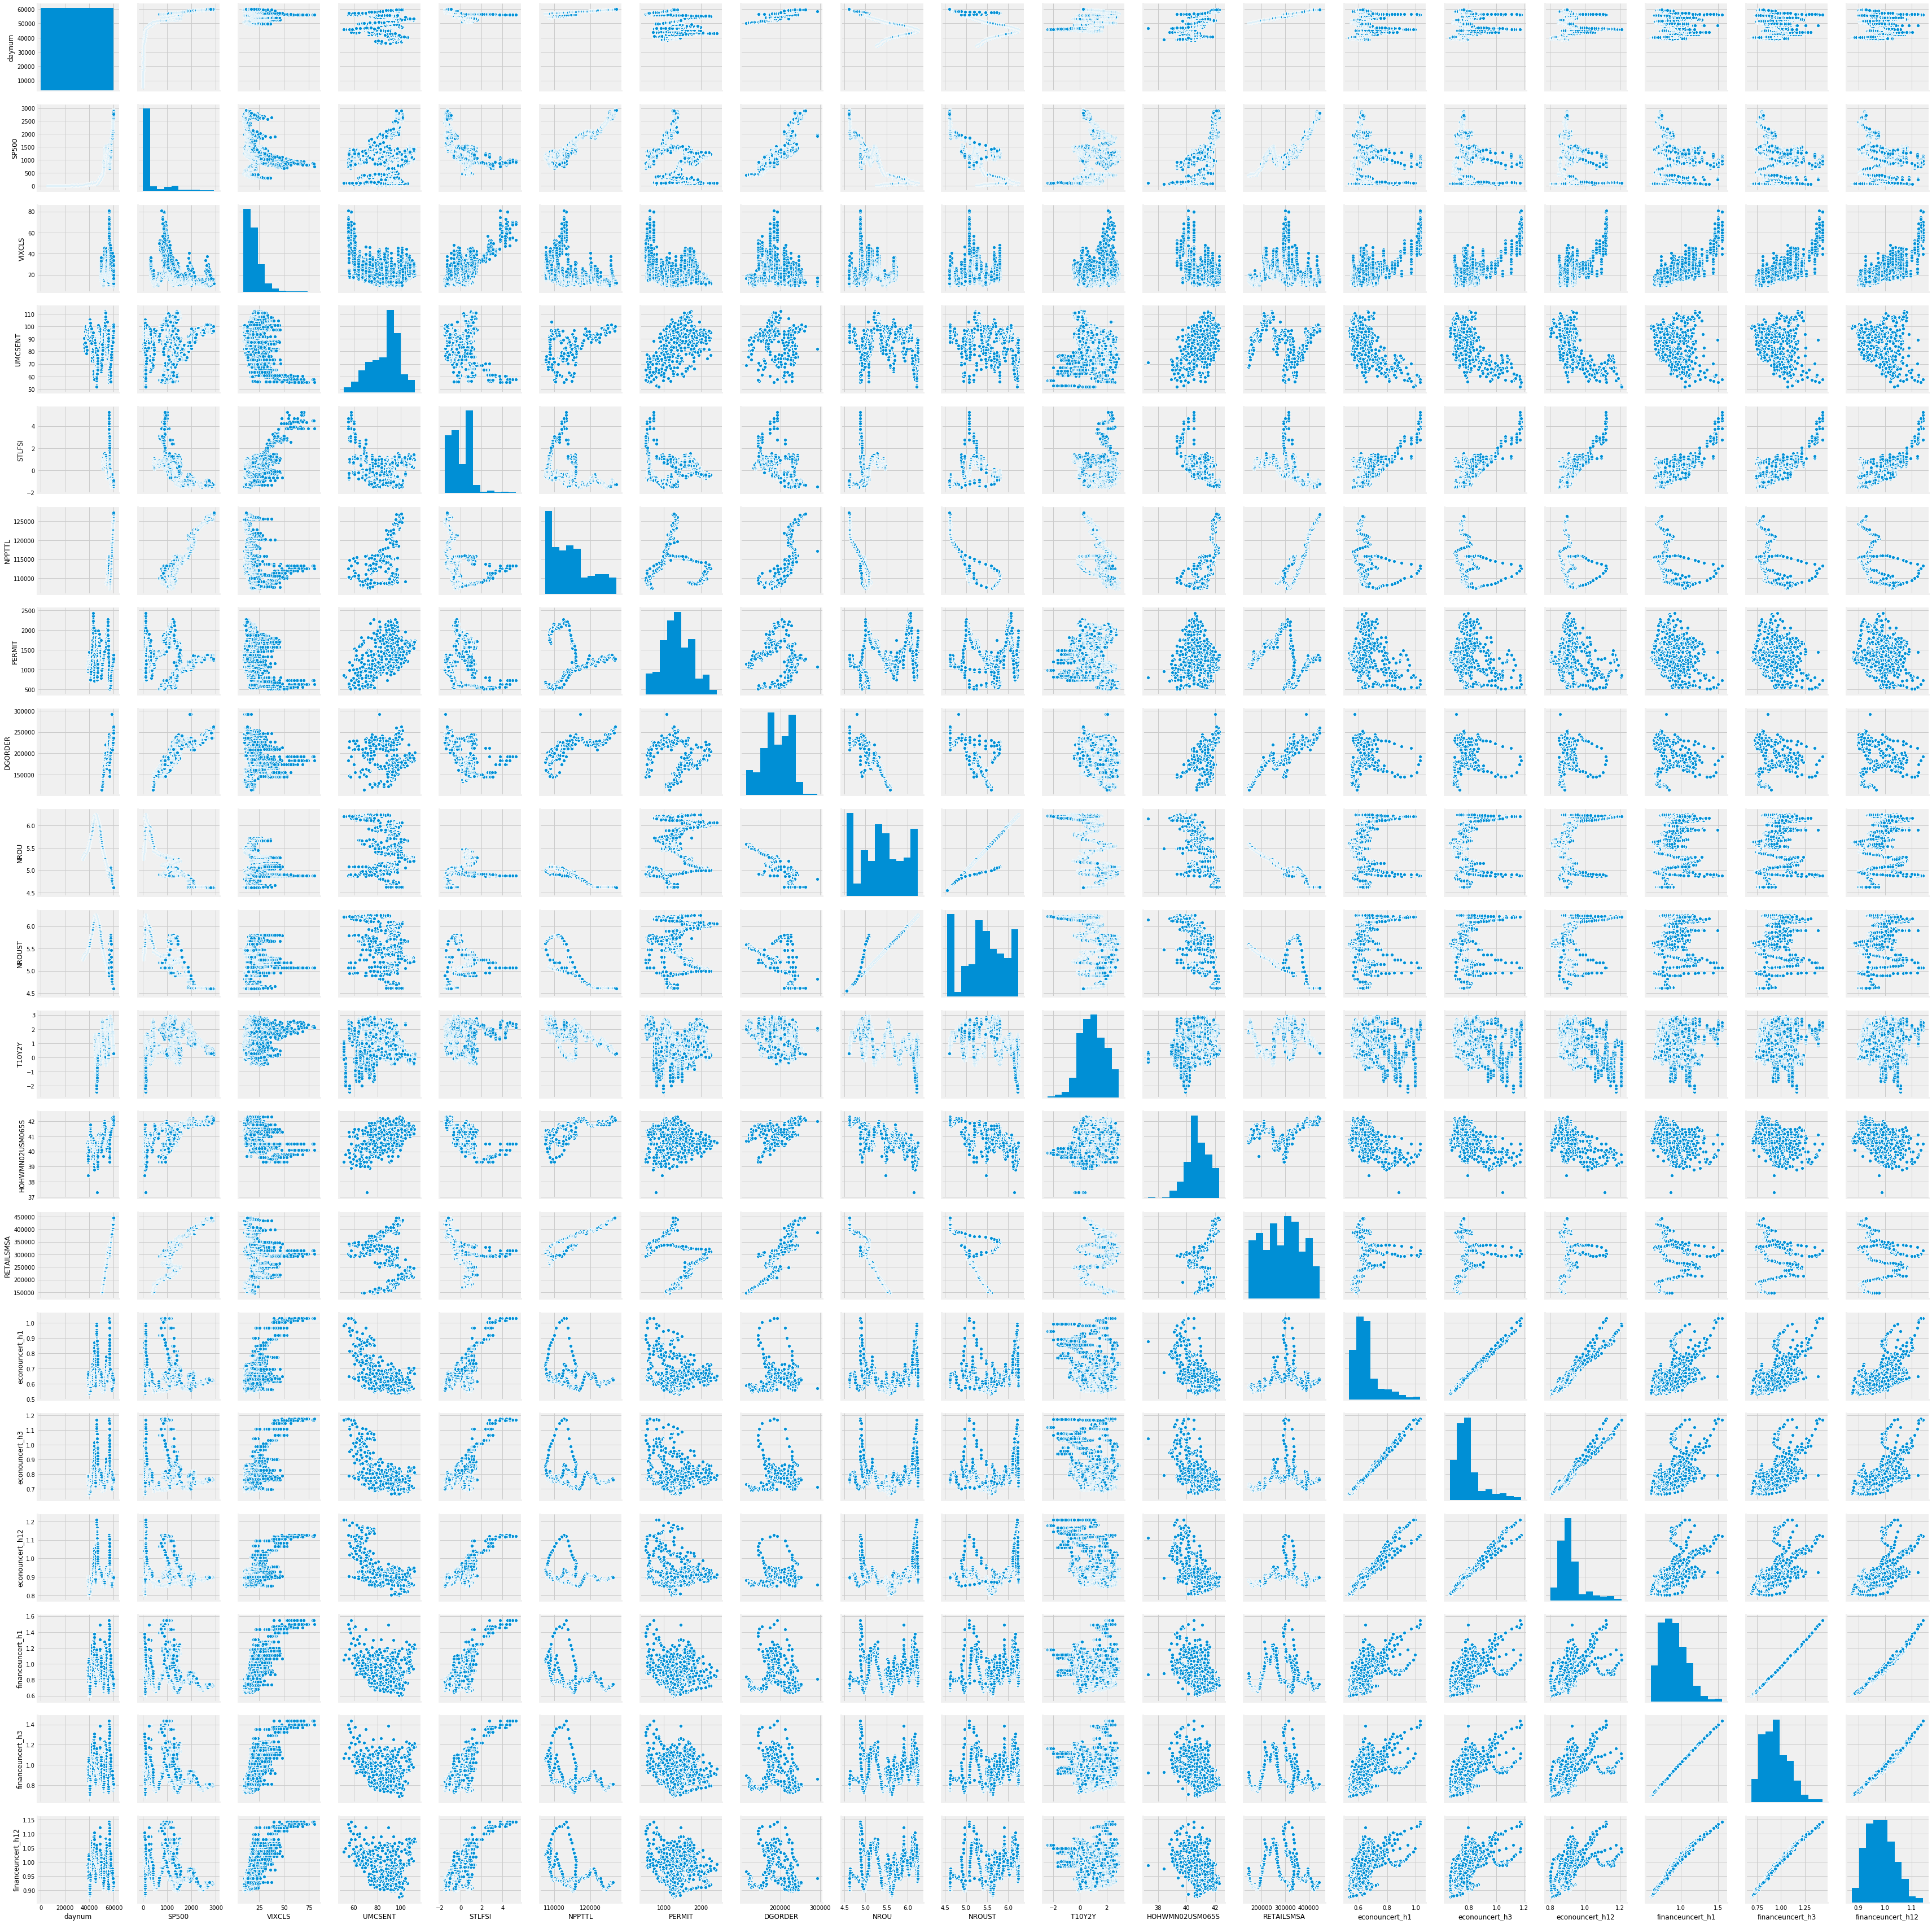

In [59]:
sns.pairplot(main_df)

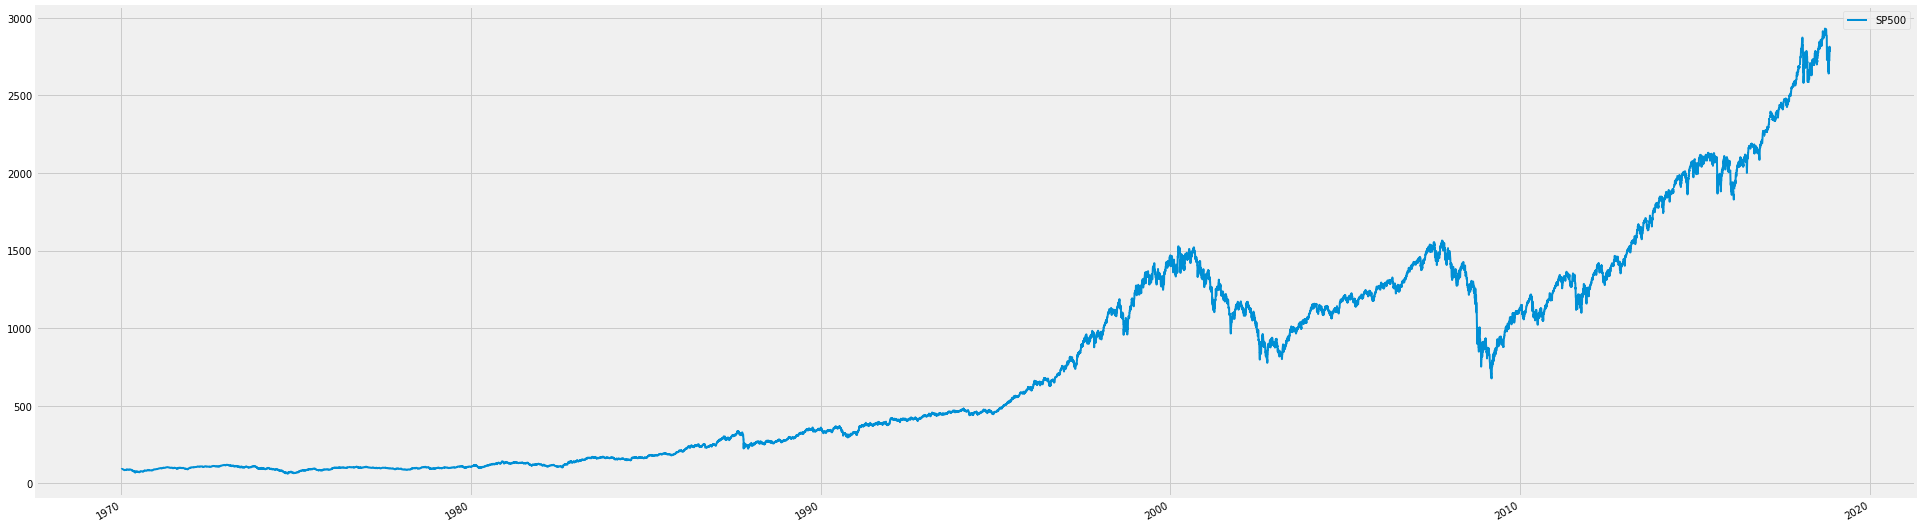

In [96]:
main_df['1970-01-01':].plot(kind='line',y=['SP500'],linewidth=2.0,figsize=(30,10))

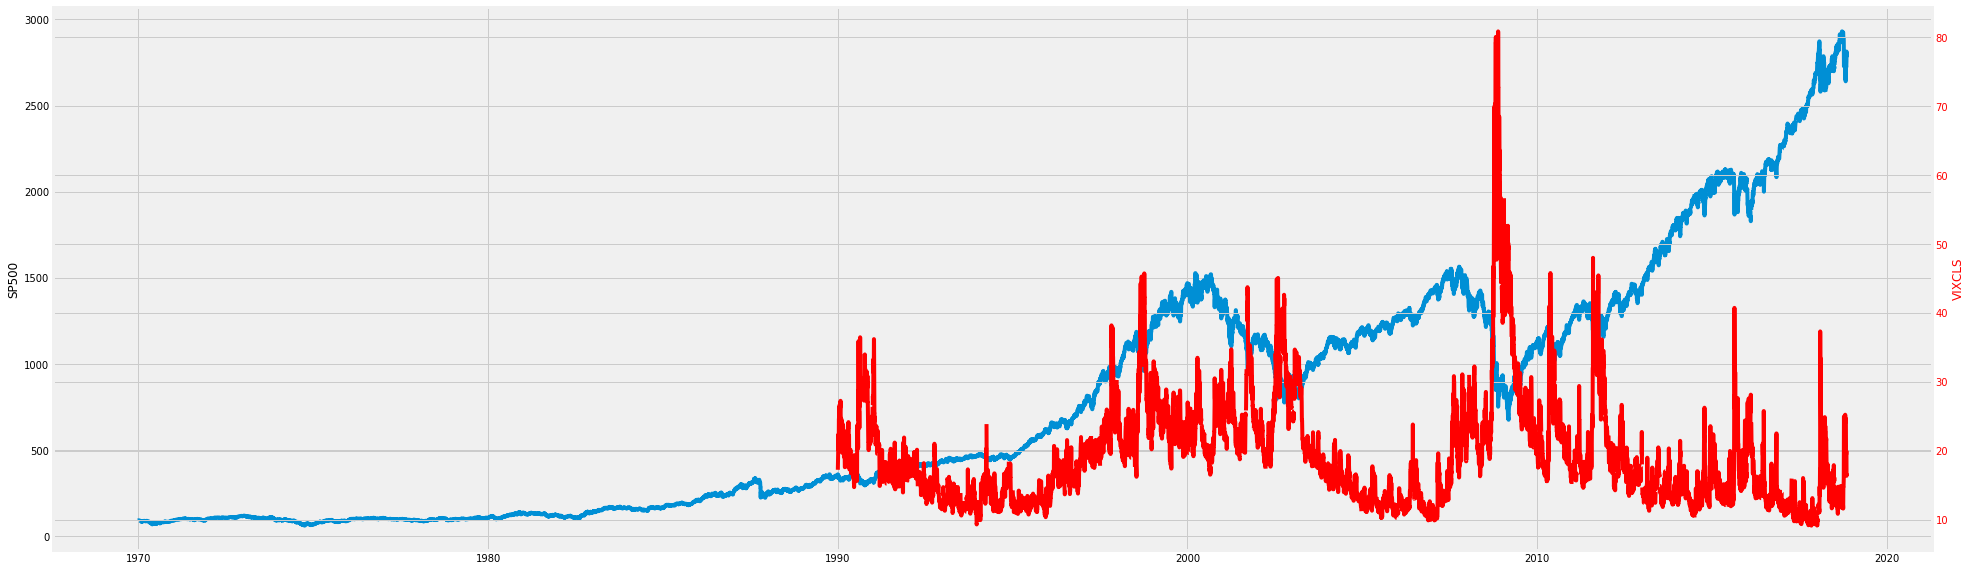

In [95]:
fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(111)
ax1.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].SP500)
ax1.set_ylabel('SP500')
ax2 = ax1.twinx()
ax2.plot(main_df['1970-01-01':].index, main_df['1970-01-01':].VIXCLS, 'r-')
ax2.set_ylabel('VIXCLS', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

In [ ]:
#Additional predictors here:
#https://cdn.titanvest.com/library/Titan_State_of_Markets.pdf
#Stock buyback activity, stock earnings growth, level of corp profits, 
#Leading indicators, such as growth in industrial transports, remain healthy
# P/E multiples vs. interest rates and inflation


"""
Subtracting the natural rate of interest—which is the neutral fed funds rate, neither contractionary nor stimulative for the economy—from the real fed funds rate gives us a gauge of how loose or tight Fed policy is. 
Leading up to past recessions, the Fed has usually hiked rates beyond the natural rate to cool the labor market and get ahead of inflation, only to inadvertently push the economy into recession. 
Looking at the current cycle, we expect quarterly rate hikes to resume in December. This will put Fed policy well into restrictive territory next year, barring a sharper increase in the natural rate than we expect.
*Natural rate is Laubach-Williams one-sided filtered estimate.
Real Fed Funds Rate – Natural Rate of Interest (r*)

https://www.frbsf.org/economic-research/files/el2017-16.pdf
Starting with a view of longer-run trends, Figure 1 plots the inflation-adjusted or “real” federal funds rate,
computed as the nominal federal funds rate minus the trailing four-quarter core personal consumption
expenditures (PCE) inflation rate. Core inflation tends to be a better predictor of future inflation because it
removes the volatile food and energy components. 

Might be able to use Potential GDP Growth as a stand-in for proper Laubach-Williams r* model

data = fred.get_series('DFF') # Effective Federal Funds Rate, Daily
print(data.tail())

#use PCE to adjust for inflation
data = fred.get_series('PCEPILFE') # Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), Monthly
print(data.tail())

#May need for calculation of r*
data = fred.get_series('GDPPOT') # Real Potential Gross Domestic Product, Quarterly
print(data.tail())

"""



"""NOTES:

Paul Comments: 
There is some work on this already (check Philly Fed and St louis Fed working papers).  I looked at these recently, highlighted the most important in red. I personally feel it is in the following order:
1.  10-2 yr spread (60%)
2.  S&P500 vs recent(last 12 or 24mo) peak/high (20%)    
3.  Change in Housing permits (10%)
4.  Change in Manufacturing Orders (5%)
5.  Consumer Sentiment (5%)

•   Manufacturing survey….leading indicator. Given lead times to build, this is historically a leading indicator. It was more pronounce when we were more of a manufacturing based society with less global influence but still predictive.
•   Housing Permits….. leading indicator given lead time to build. Also note interest rate increases slow consumer demand and construction companies know this. Somewhat correlated to yield curve.
•   Consumer sentiment….(mich survey) …leading indicator however I feel the S&P500 is a reliable gauge for this and more real time. The two series are highly correlated.

JPMorgan's proprietary model considers the levels of several economic indicators, including consumer sentiment, manufacturing sentiment, building permits, auto sales, and unemployment.
JPMorgan notes that nonfarm payrolls is actually not part of the model. But the unemployment rate is. Interestingly, a low unemployment rate can be considered an ominous sign.

“The unemployment rate enters the model in two ways," Edgerton explained. "As a near-term indicator, we watch for increases in the unemployment rate that occur near the beginning of recessions. So this morning's move down in the unemployment rate lowered the recession probability in our near-term model. But we also find the level of the unemployment rate to be one of the most useful indicators of medium-term recession risk. So the move down in unemployment raises the model's view of the risk of economic overheating in the medium run and raises the 'background risk' of recession."

Indeed, recessions begin when things are very good. It's only when reports come in that the data has turned that we realize we've been in a recession.
https://finance.yahoo.com/news/jpmorgan-recession-risk-new-high-160251309.html

Best investments in case of an inverted yield curve
https://www.wsj.com/articles/the-best-investments-in-case-of-an-inverted-yield-curve-1536545041?emailToken=e7d3ad6442c26d159eb5bc7903c7f80603yQYaTVNumvrlRPOpnMOdMNGYlKz9R0nF7hBawD18PIgfIs2FyveE1L1m8yYL2DkzsrmGL+Gt0ehEfETb7Q1TP6do5LV1+ScyBBPIcgjOqLKKtUfjtFBaeAgRiUo7m2&reflink=article_email_share

Guggenheim Models:
https://www.guggenheiminvestments.com/perspectives/macroeconomic-research/forecasting-the-next-recession
https://www.guggenheiminvestments.com/perspectives/macroeconomic-research/updating-our-outlook-for-recession-timing
Includes cycles ending in 1970, 1980, 1990, 2001, and 2007.

Paul O. - What to do just before recession: 
Between now and 12 mos from now, bond prices will have pressure so interest rate hedge ETF could better navigate this. Then swap them out 13mos (bypass short term cap gains tax) from now for non hedge versions so you can gain from price increases associate with rate decreases.  Just need to watch out for credit risk in order:
1.  Junk
2.  Investment grade Corp
3.  Muni

Paul O. - Economist from Moody's last week said the earliest predictor of a recession is when UE falls below the natural rate of unemployment. This lead is 3yrs, it happened June-2017.

####OFFICIAL RECESSION DATES
https://www.nber.org/cycles.html

#Natural rate of interest modelling: 
https://www.frbsf.org/economic-research/files/wp2016-11.pdf
https://www.frbsf.org/economic-research/files/el2017-16.pdf

#Economic Uncertainty Index (increases sharply just before recession) (not to be confused with Economic Policy Uncertainty)
https://www.sydneyludvigson.com/data-and-appendixes/
https://www.sydneyludvigson.com/s/MacroFinanceUncertainty_2018AUG_update.zip

#Leading Economic Index (LEI)
The Conference Board Leading Economic Index (LEI), which measures 10 key variables, is itself a recession predictor, albeit a fallible one. 
It has been irreverently said that the LEI predicted 15 out of the last eight recessions. 
Nevertheless, growth in the LEI always slows on a year-over-year basis heading into a recession, and turns negative about seven months out, on average. 
Looking at the current cycle, LEI growth of 4 percent over the past year has been on par with past cycles two years before a recession, and we will be watching for a deceleration over the course of the coming year.
Leading Economic Index, Year-over-Year % Change

https://www.conference-board.org/data/datasearch.cfm?cid=1&output=2&sector=BCI-01A%20-%20Composite%20Indexes-Leading%20Economic%20Indicators
#Could scrape the index from their public releases:
https://www.conference-board.org/data/bcicountry.cfm?cid=1

###USE FACEBOOK PROPHET FOR TIME SERIES MODEL
http://www.degeneratestate.org/posts/2017/Jul/24/making-a-prophet/
https://facebook.github.io/prophet/docs/quick_start.html#python-api
https://peerj.com/preprints/3190.pdf

"""